In [138]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
%matplotlib inline

torch.set_printoptions(threshold=100000)

In [28]:
data_dir = "../Cyclist_Detection/raw/images"

In [29]:
label_dir = "../Cyclist_Detection/raw/labels"

In [32]:
A = sorted(os.listdir(label_dir))

In [30]:
sorted(os.listdir(data_dir))

['000000.jpg',
 '000001.jpg',
 '000002.jpg',
 '000003.jpg',
 '000004.jpg',
 '000005.jpg',
 '000006.jpg',
 '000007.jpg',
 '000008.jpg',
 '000009.jpg',
 '000010.jpg',
 '000011.jpg',
 '000012.jpg',
 '000013.jpg',
 '000014.jpg',
 '000015.jpg',
 '000016.jpg',
 '000017.jpg',
 '000018.jpg',
 '000019.jpg',
 '000020.jpg',
 '000021.jpg',
 '000022.jpg',
 '000023.jpg',
 '000024.jpg',
 '000025.jpg',
 '000026.jpg',
 '000027.jpg',
 '000028.jpg',
 '000029.jpg',
 '000030.jpg',
 '000031.jpg',
 '000032.jpg',
 '000033.jpg',
 '000034.jpg',
 '000035.jpg',
 '000036.jpg',
 '000037.jpg',
 '000038.jpg',
 '000039.jpg',
 '000040.jpg',
 '000041.jpg',
 '000042.jpg',
 '000043.jpg',
 '000044.jpg',
 '000045.jpg',
 '000046.jpg',
 '000047.jpg',
 '000048.jpg',
 '000049.jpg',
 '000050.jpg',
 '000051.jpg',
 '000052.jpg',
 '000053.jpg',
 '000054.jpg',
 '000055.jpg',
 '000056.jpg',
 '000057.jpg',
 '000058.jpg',
 '000059.jpg',
 '000060.jpg',
 '000061.jpg',
 '000062.jpg',
 '000063.jpg',
 '000064.jpg',
 '000065.jpg',
 '000066.j

In [31]:
sorted(os.listdir(label_dir))

['000000.txt',
 '000001.txt',
 '000002.txt',
 '000003.txt',
 '000004.txt',
 '000005.txt',
 '000006.txt',
 '000007.txt',
 '000008.txt',
 '000009.txt',
 '000010.txt',
 '000011.txt',
 '000012.txt',
 '000013.txt',
 '000014.txt',
 '000015.txt',
 '000016.txt',
 '000017.txt',
 '000018.txt',
 '000019.txt',
 '000020.txt',
 '000021.txt',
 '000022.txt',
 '000023.txt',
 '000024.txt',
 '000025.txt',
 '000026.txt',
 '000027.txt',
 '000028.txt',
 '000029.txt',
 '000030.txt',
 '000031.txt',
 '000032.txt',
 '000033.txt',
 '000034.txt',
 '000035.txt',
 '000036.txt',
 '000037.txt',
 '000038.txt',
 '000039.txt',
 '000040.txt',
 '000041.txt',
 '000042.txt',
 '000043.txt',
 '000044.txt',
 '000045.txt',
 '000046.txt',
 '000047.txt',
 '000048.txt',
 '000049.txt',
 '000050.txt',
 '000051.txt',
 '000052.txt',
 '000053.txt',
 '000054.txt',
 '000055.txt',
 '000056.txt',
 '000057.txt',
 '000058.txt',
 '000059.txt',
 '000060.txt',
 '000061.txt',
 '000062.txt',
 '000063.txt',
 '000064.txt',
 '000065.txt',
 '000066.t

13674

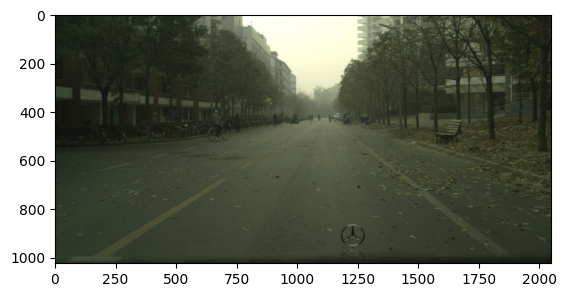

In [26]:
img = torchvision.io.read_image("../Cyclist_Detection/raw/images/000000.jpg")
img.size()
img = torchvision.transforms.ToPILImage()(img)
plt.imshow(img)
plt.show()

In [36]:
f = open(os.path.join(label_dir,A[5]),'r')

In [145]:
def yolo_load_txt(path,target):
    """Used for loading .txt files with labels in the yolo format for object detection"""
    labels_dir = sorted(os.listdir(path))
    for dir in labels_dir:
        with open(os.path.join(path,dir),'r') as txt:
            txt_lines = txt.readlines()
            txt.close()

        single_yolo = torch.empty((len(txt_lines),5))

        for j in range(len(txt_lines)):
            txt_lines[j] = txt_lines[j].strip()
            single_line = torch.tensor(list(map(float,txt_lines[j].split(" "))))
            single_yolo[j] = single_line

        torch.save(single_yolo,os.path.join(target,dir))



In [144]:
yolo_load_txt(label_dir)

RuntimeError: stack expects each tensor to be equal size, but got [1, 5] at entry 0 and [2, 5] at entry 5

In [ ]:
torch.save()